Лабораторные работы по дисциплине "Основы машинного обучения"
Выполнил для других студентов

# Лабораторная работа №1

Требования:
- Число столбцов признаков – не менее 10
- Число записей – не менее 10000
- Набор данных имеет пропуски

Задачи:
- Очистка данных (удаление пропусков, нормализация, удаление дубликатов)
- Визуализация значимых признаков
- Диаграммы рассеяния
- Ящики с усами
- Гистограммы
- Корреляция данных (матрица корреляций)

Скачаем датасет (https://www.kaggle.com/datasets/shahlaliaquat/ibm-stock-prices-19802025)

In [ ]:
from pathlib import Path
import requests

RAW_URL = "https://raw.githubusercontent.com/hazlmar/OOP1/0daab253bfe9aa94c0cf2e0eaa33fc93d3e82ebd/IBM_Stock_1980_2025_price_increase_categorical.csv"
DEST = Path("/content/data/IBM_Stock_1980_2025_missing.csv")
DEST.parent.mkdir(parents=True, exist_ok=True)

r = requests.get(RAW_URL, timeout=60)
r.raise_for_status()

DEST.write_bytes(r.content)
print(f"Saved to {DEST} ({DEST.stat().st_size/1_000_000:.2f} MB)")

Saved to /content/data/IBM_Stock_1980_2025_missing.csv (1.20 MB)


В датасете IBM_Stock_1980_2025.csv содержится более 11 000 строк и 10 признаков, описывающих динамику стоимости акций компании IBM с 1980 по 2025 год.
Выберем необходимые признаки для анализа и построения модели.

Целевым признаком для предсказания будет Daily_Delta (Дневное отклонение стартовой и конечной цены)

---

### Из числовых признаков возьмём:

* Open (Цена открытия)
* High (Максимальная цена за день)
* Low (Минимальная цена за день)
* Close (Цена закрытия)
* Adj Close (Скорректированная цена закрытия с учётом сплитов и дивидендов)
* Volume (Объём торгов)
* Dividends (Начисленные дивиденды за день)
* Stock Splits (Количество сплитов акций в указанный день)
* Adj Factor (Корректирующий коэффициент для пересчёта цен)

---

### Из категориальных / временных признаков возьмём:

* Date (Дата торгового дня)


Загрузим библиотеки

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

Setup Complete


Загрузка датасета

In [ ]:
filepath = "/content/data/IBM_Stock_1980_2025_missing.csv"

df = pd.read_csv(filepath)

В переменной filepath хранится путь до датасета. В переменной df хранится dataframe по нашему датасету

Посмотрим типы столбцов

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11488 entries, 0 to 11487
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            10958 non-null  object 
 1   Open            10948 non-null  float64
 2   High            10916 non-null  float64
 3   Low             10930 non-null  float64
 4   Close           10899 non-null  float64
 5   Adj Close       10920 non-null  float64
 6   Volume          10929 non-null  float64
 7   Dividends       10915 non-null  float64
 8   Stock Splits    11488 non-null  int64  
 9   Adj Factor      10930 non-null  float64
 10  Price_Increase  11488 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 987.4+ KB


Посмотрим на сами данные

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Adj Factor,Price_Increase
0,1980-01-02,15.057361,15.415870,14.937859,14.937859,0.965845,1723808.0,0.0,5,0.064657,Down
1,1980-01-03,14.937859,15.176864,14.639101,15.176864,0.981298,2553495.0,0.0,9,0.064657,Up
2,1980-01-04,15.176864,15.236616,15.057361,15.146989,0.979366,1978195.0,0.0,5,0.064657,Down
3,1980-01-07,15.146989,15.146989,14.967734,15.087237,0.975503,1480718.0,0.0,1,0.064657,Down
4,1980-01-08,15.087237,16.132887,14.967734,16.103010,1.041180,NaN,0.0,9,0.064657,Up


Посмотрим пустые значения столбцов

In [ ]:
df.isna().sum()

,0
Date,530
Open,540
High,572
Low,558
Close,589
Adj Close,568
Volume,559
Dividends,573
Stock Splits,0
Adj Factor,558


все требования к лабораторной работе выполнены.
- [x] Число столбцов признаков - не менее 10
- [x] Число записей - не менее 10000
- [x] Набор данных имеет пропуски

Обозначм столбец с целевым признаком

In [ ]:
id_column = "Date"
target_column = "Daily_Delta"

Отбросим некоторые признаки

In [ ]:
df = df.sort_values('Date').copy()
df['Daily_Delta'] = (df["Close"] - df["Open"])
df = df.drop(columns=['Price_Increase'])

Выделим категориальные и числовые признаки


In [ ]:
numerical_columns = [
    'Dividends','Open','High','Low','Volume','Stock Splits','Adj Factor'
]

categorical_columns = [
    'Date'
]

Очистим столбцы с пустыми категориальными признаками

In [ ]:
for column in df.columns:
    if df[column].dtype not in ('int64', 'float64'):
        df = df.dropna(subset=[column])
    elif column == target_column:
        df = df.dropna(subset=[column])



Проверим есть ли дубликаты и удалим их при наличии

In [ ]:
print("Точных дублей:", df.duplicated().sum())
df = df.drop_duplicates()

print("дубликатов ID:", df.duplicated(subset=[id_column]).sum())
df = df.drop_duplicates(subset=[id_column], keep='first')

X_cols = df.columns.difference([id_column, target_column])
print("дублей по X:", df.duplicated(subset=X_cols).sum())

Точных дублей: 0
дубликатов ID: 0
дублей по X: 0


Разделим данные на обучающие и тренировочные в пропорции 70/30

In [ ]:
df_sorted = df.sort_values('Date')
split_idx = int(len(df_sorted)*0.7)
train = df_sorted.iloc[:split_idx]
test  = df_sorted.iloc[split_idx:]
X_train, y_train = train.drop([id_column, target_column, 'Close'], axis=1), train[target_column]
X_test,  y_test  = test.drop([id_column, target_column, 'Close'], axis=1),  test[target_column]

Заполним медианой строки с пустыми численными признаками при помощи SimpleImputer

In [ ]:
from sklearn.impute import SimpleImputer

imp_num = SimpleImputer(strategy='median')

X_train = pd.DataFrame(
    imp_num.fit_transform(X_train[numerical_columns]),
    columns = numerical_columns,
    index = X_train.index
)

X_test = pd.DataFrame(
    imp_num.transform(X_test[numerical_columns]),
    columns = numerical_columns,
    index = X_test.index
)

Проверим результат

In [ ]:
X_train.isna().sum()

,0
Dividends,0
Open,0
High,0
Low,0
Volume,0
Stock Splits,0
Adj Factor,0


In [ ]:
X_test.isna().sum()

,0
Dividends,0
Open,0
High,0
Low,0
Volume,0
Stock Splits,0
Adj Factor,0


Сделаем функцию для обнаружения выбросов

In [ ]:
def sigma_bounds(df, cols, k=3.0):
    b = {}
    for c in cols:
        s = df[c].dropna()
        m = s.mean() # mean
        sd = s.std(ddof=1) # std value
        b[c] = (m - k*sd, m + k*sd) # (lower bound, upper bound)
    return b

def outlier_indices_by_bounds(df, bounds):
    out = set()
    for c, (lower_bound, upper_bound) in bounds.items():
        if c in df.columns:
            idx = df.index[(df[c] < lower_bound) | (df[c] > upper_bound)]
            out |= set(idx)
    return out

Первичный отбор (до чистки) по всем численным признакам

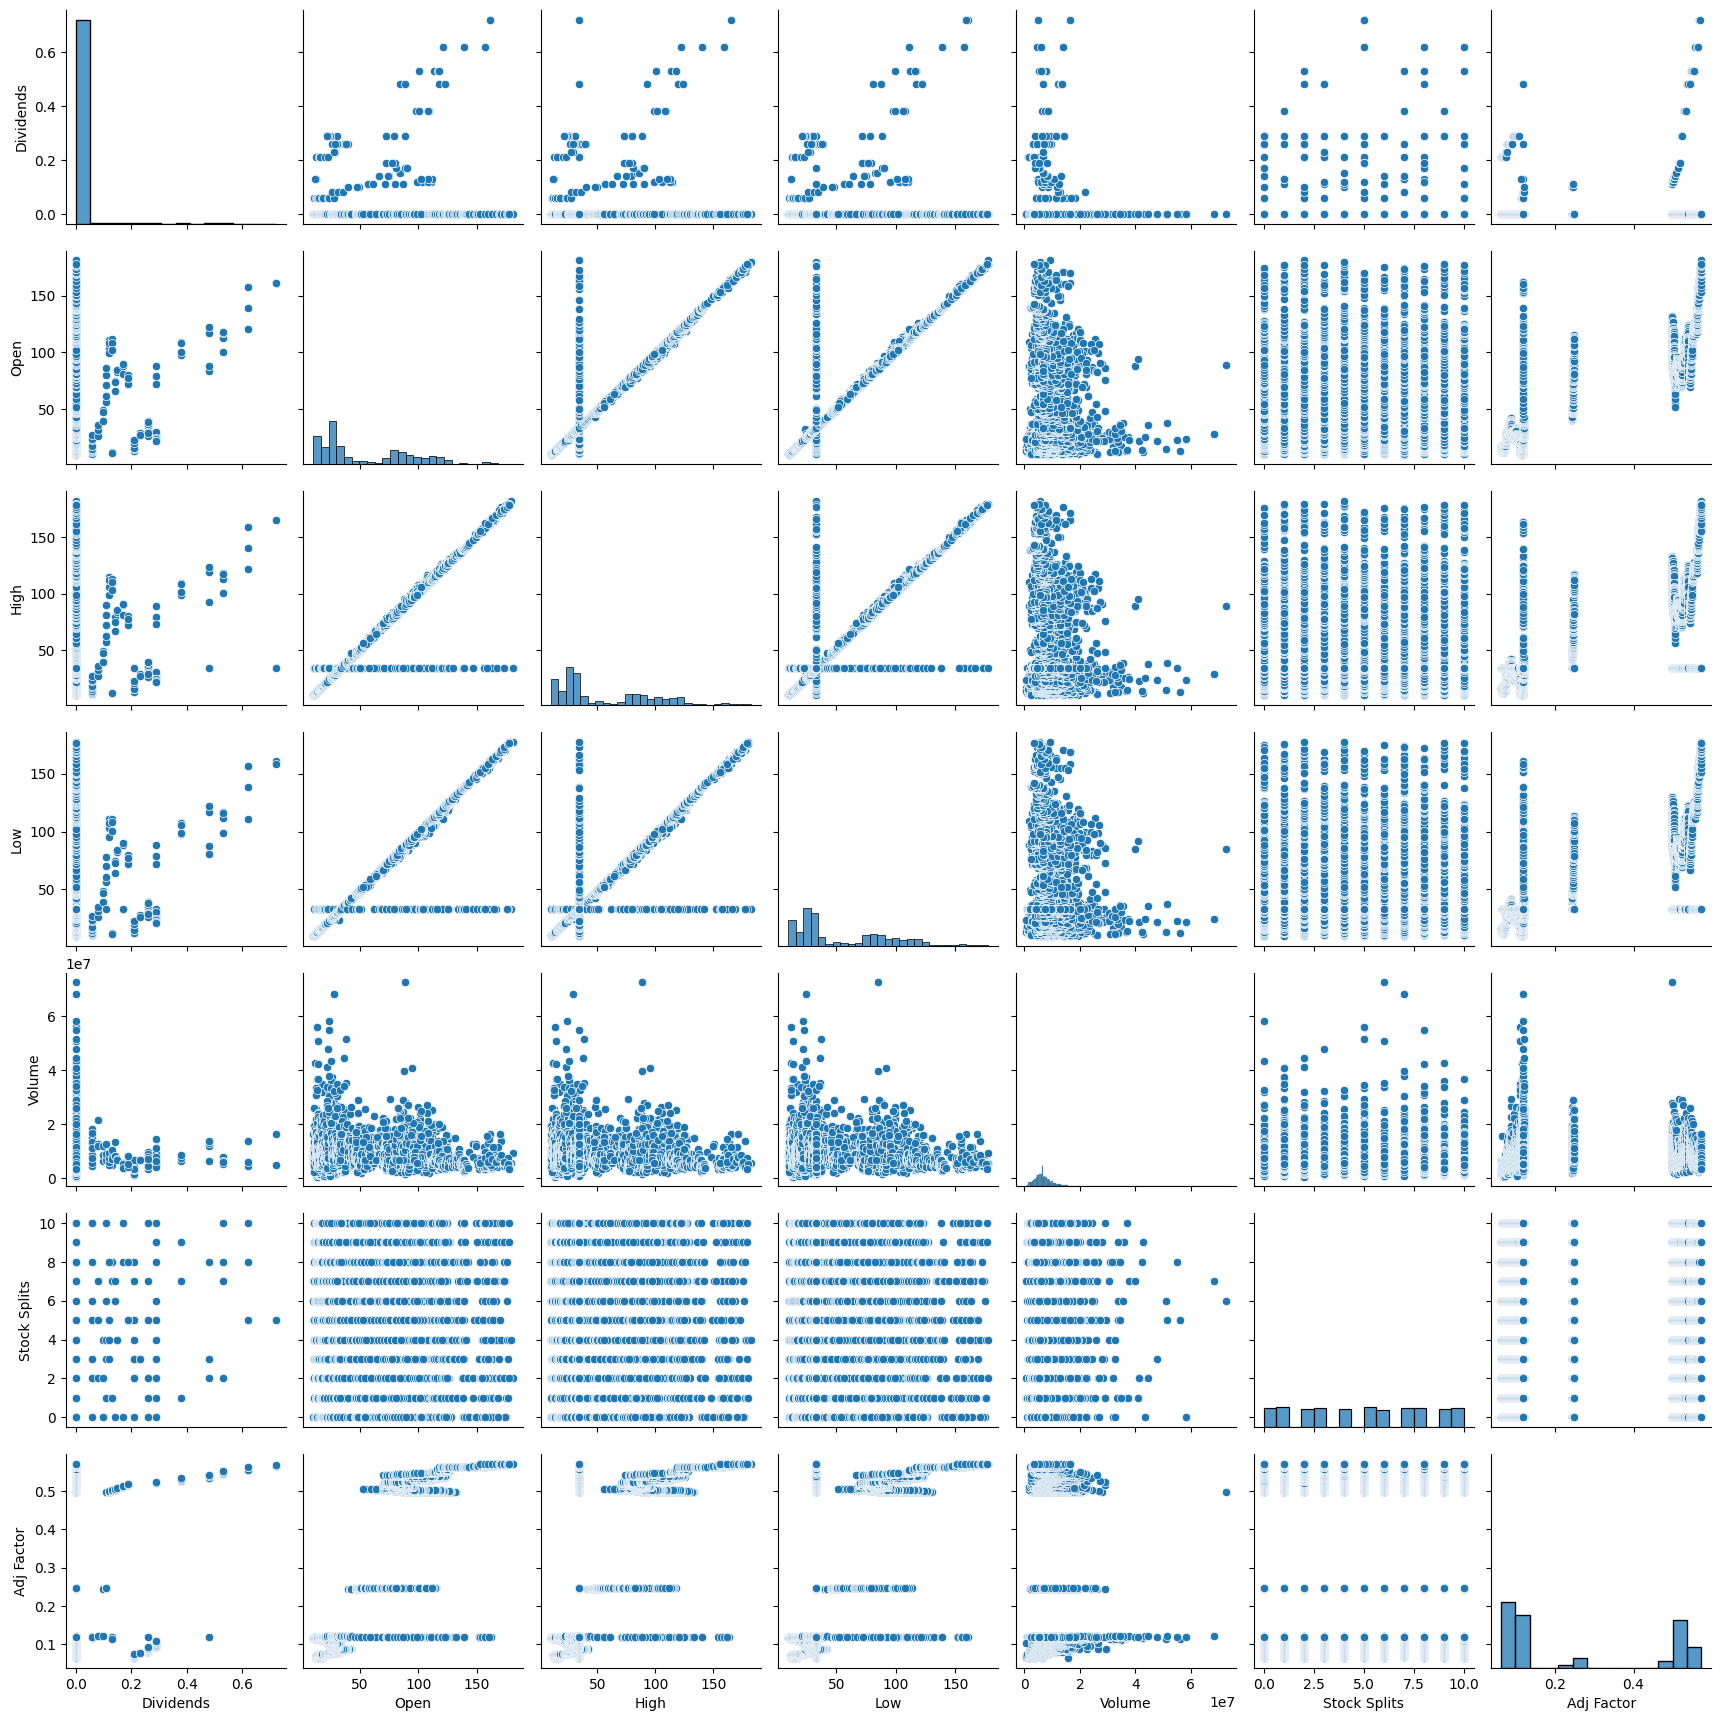

In [ ]:
sns.pairplot(X_train[numerical_columns])

Сбор всех выбросов во всех колонках и их удаление

In [ ]:
out = set()

bounds = sigma_bounds(X_train, numerical_columns, k=3.0)
out = outlier_indices_by_bounds(X_train, bounds)

df = df.drop(index=list(out))
X_train = X_train.drop(index=list(out))
y_train = y_train.loc[X_train.index]

print(len(X_train) == len(y_train))

True


Повторный просмотр корреляции

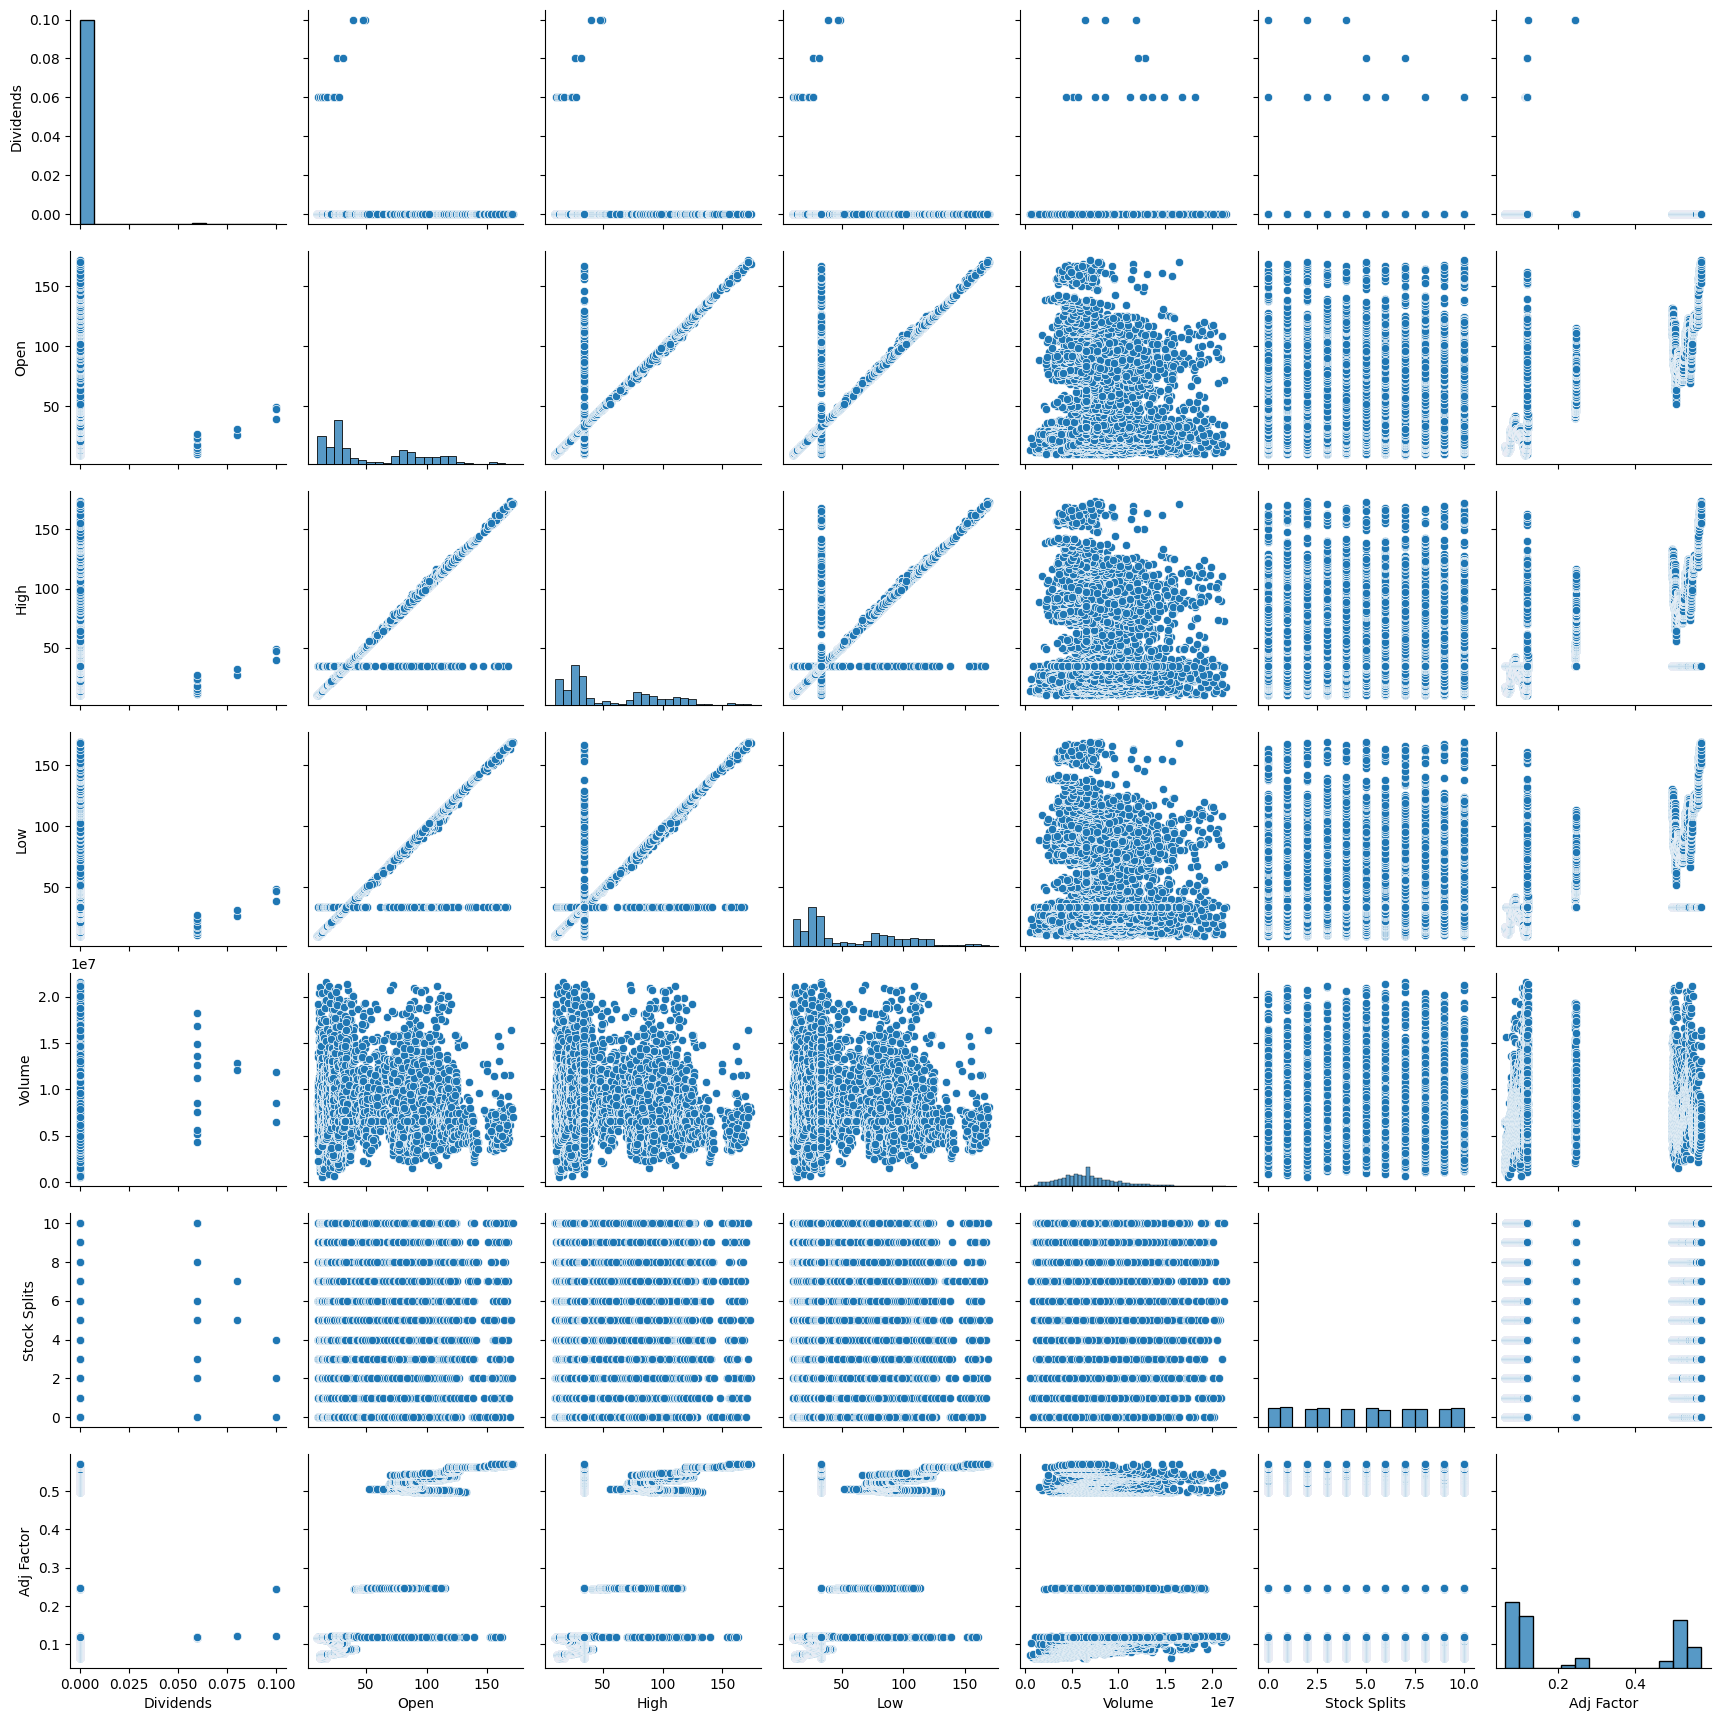

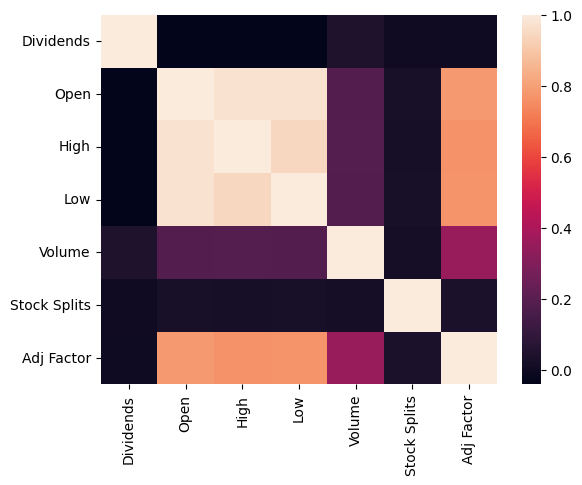

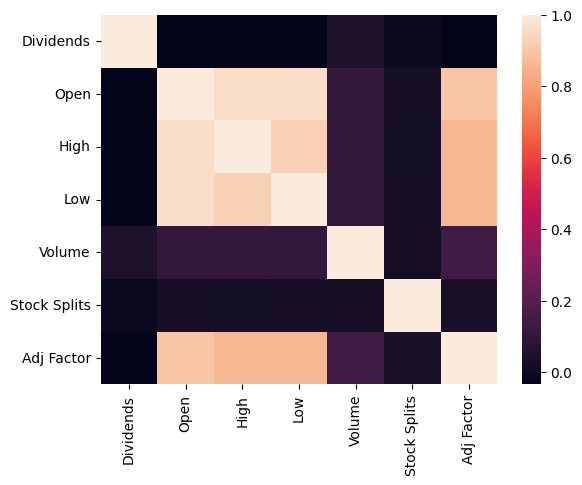

In [ ]:
sns.pairplot(X_train[numerical_columns]); plt.show()
sns.heatmap(X_train[numerical_columns].corr(method='spearman')); plt.show()
sns.heatmap(X_train[numerical_columns].corr(method='pearson')); plt.show()

Применим полученный результат выбросов и на тестовые данные

In [ ]:
for col, (lower, upper) in bounds.items():
  if col in X_test.columns:
    if X_test[col].dtype == 'int64':
      X_test.loc[:, col] = (
        X_test[col]
          .clip(lower=int(np.floor(lower)), upper=int(np.ceil(upper)))
                .astype(X_test[col].dtype)
          )
    else:
      X_test.loc[:, col] = X_test[col].clip(lower=lower, upper=upper)

Теперь сделаем диаграмму рассеяния, но для начала посмотрим матрицу корреляций для выявления признаков с наибольшей (пусть и маленькой) взаимосвзяью

Для начала посмотрим корреляцию между числовыми признаками

In [ ]:
corr = X_train[numerical_columns].corr(method='pearson')
corr

,Dividends,Open,High,Low,Volume,Stock Splits,Adj Factor
Dividends,1.000000,-0.034857,-0.034080,-0.034007,0.045023,-0.004684,-0.028462
Open,-0.034857,1.000000,0.962519,0.959590,0.104975,0.022988,0.891453
High,-0.034080,0.962519,1.000000,0.923229,0.104615,0.020960,0.859463
Low,-0.034007,0.959590,0.923229,1.000000,0.099213,0.025442,0.861127
Volume,0.045023,0.104975,0.104615,0.099213,1.000000,0.021780,0.136360
Stock Splits,-0.004684,0.022988,0.020960,0.025442,0.021780,1.000000,0.033155
Adj Factor,-0.028462,0.891453,0.859463,0.861127,0.136360,0.033155,1.000000


Теперь посмотрим корреляцию между целевым признаком и численными признаками

In [ ]:
corr_with_y = X_train[numerical_columns].corrwith(y_train)
corr_with_y.sort_values(ascending=False)

,0
High,0.041672
Low,0.037753
Adj Factor,0.035933
Open,0.029099
Stock Splits,0.014039
Volume,0.003419
Dividends,-0.010456


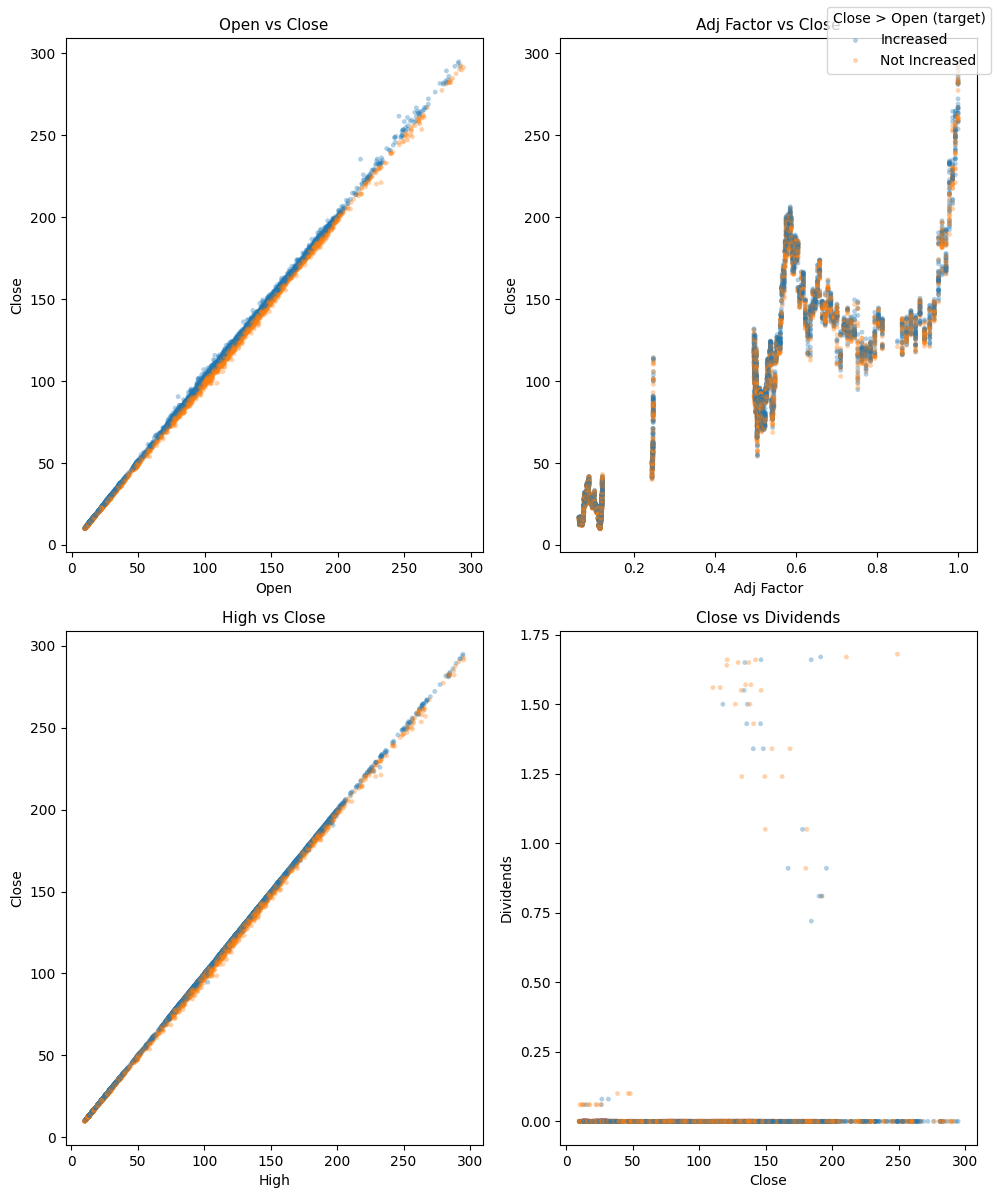

In [ ]:
# 2) Пары для графиков
pairs = [
    ('Open', 'Close', 'Open vs Close'),
    ('Adj Factor', 'Close', 'Adj Factor vs Close'),
    ('High', 'Close', 'High vs Close'),
    ('Close', 'Dividends', 'Close vs Dividends'),
]

# 3) Палитра и порядок меток
hue_col = 'target'
hue_order = ['Increased', 'Not Increased']
palette = {'Increased': 'C0', 'Not Increased': 'C1'}

# Add the 'target' column
df['target'] = np.where(df['Close'] > df['Open'], 'Increased', 'Not Increased')

# 4) Построение графиков + общая легенда
fig, axes = plt.subplots(2, 2, figsize=(10, 12))
axes = axes.ravel()
handles, labels = None, None

for i, (x, y, title) in enumerate(pairs):
    ax = axes[i]
    g = sns.scatterplot(
        data=df, x=x, y=y,
        hue=hue_col, hue_order=hue_order,
        palette=palette, s=12, alpha=0.35, linewidth=0,
        ax=ax, legend=('full' if i == 0 else False)
    )
    if i == 0:
        handles, labels = g.get_legend_handles_labels()
        g.legend_.remove()

    ax.set_title(title, fontsize=11)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

if handles:
    fig.legend(handles, labels, title='Close > Open (target)',
               loc='upper right', frameon=True)

plt.tight_layout()
plt.show()

In [ ]:
import plotly.graph_objects as go

df_plot = df.loc[df['Low'].notna() & df['High'].notna() & df['Open'].notna()].copy()
df_plot['target'] = np.where(df_plot['Close'] > df_plot['Open'], 'Increased', 'Not Increased')

# --- Берём центральные 50% по 'Low', чтобы приглушить экстремумы ---
low_q, high_q = df_plot['Low'].quantile([0.25, 0.75])
df_plot = df_plot[(df_plot['Low'] >= low_q) & (df_plot['Low'] <= high_q)]

# --- Бины по 'Low' (можно менять step: 20, 30, 50, 100 и т.д.) ---
step = 50
lo = int(np.floor(df_plot['Low'].min() / step) * step)
hi = int(np.ceil(df_plot['Low'].max() / step) * step)
bins = np.arange(lo, hi + step, step)
labels = [f'{b}-{b + step - 1}' for b in bins[:-1]]

df_plot['hr_bin'] = pd.cut(df_plot['Low'], bins=bins, labels=labels, right=False)

# --- Палитра и имена классов ---
colors = {'Increased': '#1f77b4', 'Not Increased': '#d62728'}
classes = [('Increased', 'h'), ('Not Increased', 'd')]  # offsetgroup для группировки

# --- Построение box-графиков Open по биннам Low, раздельно по target ---
fig = go.Figure()
for cls, off in classes:
    m = df_plot['target'].eq(cls) & df_plot['High'].notna()
    fig.add_trace(go.Box(
        x=df_plot.loc[m, 'hr_bin'],
        y=df_plot.loc[m, 'Open'],
        name=cls,
        marker_color=colors[cls],
        boxpoints='outliers',
        boxmean=True,
        opacity=0.85,
        offsetgroup=off,
        alignmentgroup='all',
    ))

fig.update_layout(
    xaxis_title=f'Low (биновка по {step})',
    yaxis_title='Open',
    boxmode='group',
    template='plotly_white',
    height=520,
    width=950,
    legend_title_text='Target (Close > Open)'
)
fig.update_xaxes(categoryorder='array', categoryarray=labels)
fig.show()

Построим гистограммы для целевого признака и

Open
Close
Volume

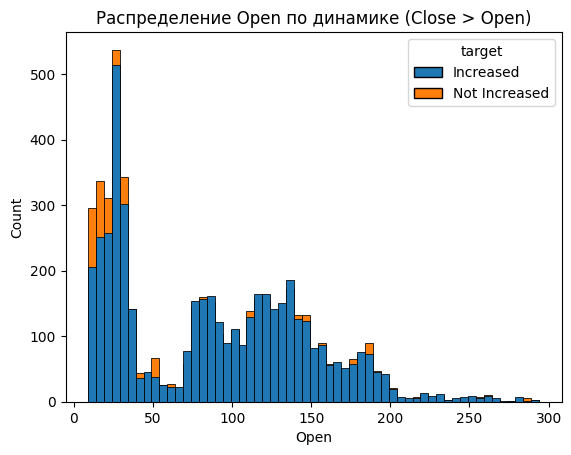

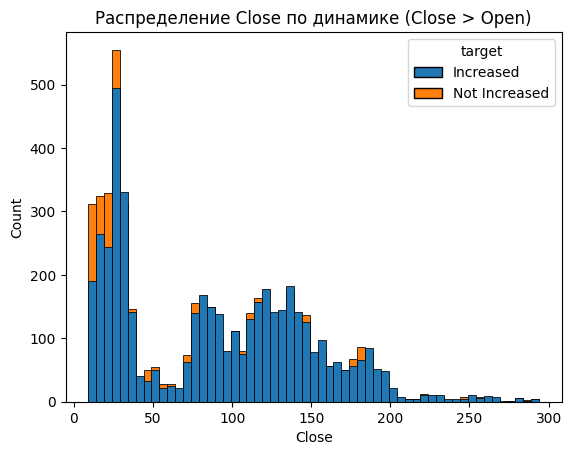

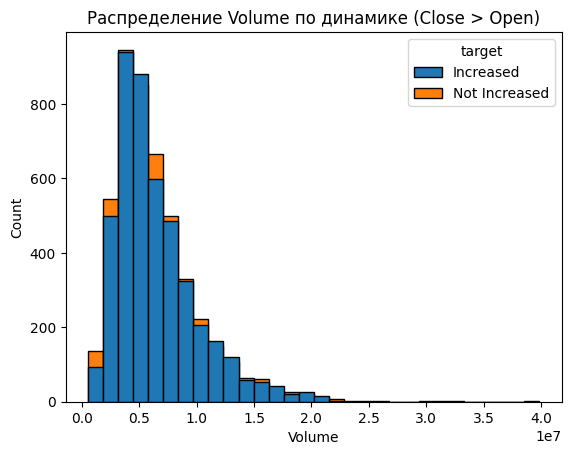

In [ ]:
# (опц.) фиксированная палитра, чтобы цвета не прыгали
palette = {'Increased': 'C0', 'Not Increased': 'C1'}

# Ensure 'target' column exists
if 'target' not in df.columns:
  df['target'] = np.where(df['Close'] > df['Open'], 'Increased', 'Not Increased')


# Гистограмма Open
sns.histplot(
    data=df, x='Open', hue='target', hue_order=['Increased', 'Not Increased'],
    multiple='layer', stat='count',
    bins=range(int(df['Open'].min()), int(df['Open'].max()) + 1, 5),
    common_bins=True, alpha=1, palette=palette
)
plt.title('Распределение Open по динамике (Close > Open)')
plt.xlabel('Open'); plt.ylabel('Count')
plt.show()

# Гистограмма Close
sns.histplot(
    data=df, x='Close', hue='target', hue_order=['Increased', 'Not Increased'],
    multiple='layer', stat='count',
    bins=range(int(df['Close'].min()), int(df['Close'].max()) + 1, 5),
    common_bins=True, alpha=1, palette=palette
)
plt.title('Распределение Close по динамике (Close > Open)')
plt.xlabel('Close'); plt.ylabel('Count')
plt.show()

# Убедимся, что Volume — числовой
df['Volume'] = df['Volume'].astype(str).str.replace(',', '', regex=False).astype(float)

# Гистограмма Volume
sns.histplot(
    data=df, x='Volume', hue='target', hue_order=['Increased', 'Not Increased'],
    multiple='layer', stat='count',
    bins=30, common_bins=True, alpha=1, palette=palette
)
plt.title('Распределение Volume по динамике (Close > Open)')
plt.xlabel('Volume'); plt.ylabel('Count')
plt.show()

Масштабируем числовые признаки

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
X_train[numerical_columns] = scaler_X.fit_transform(X_train[numerical_columns])
X_test[numerical_columns]  = scaler_X.transform(X_test[numerical_columns])

In [ ]:
X_train[numerical_columns].head()

,Dividends,Open,High,Low,Volume,Stock Splits,Adj Factor
0,-0.047675,-1.031873,-1.016625,-1.017321,-1.519873,0.008381,-0.978442
1,-0.047675,-1.034904,-1.022746,-1.025143,-1.287855,1.265579,-0.978442
2,-0.047675,-1.028842,-1.021216,-1.014192,-1.448735,0.008381,-0.978442
3,-0.047675,-1.029600,-1.023511,-1.016539,-1.587852,-1.248817,-0.978442
4,-0.047675,-1.031115,-0.998261,-1.016539,-0.164737,1.265579,-0.978442


Категориальные признаки для преобразования отсутствуют

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6713 entries, 0 to 8025
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Dividends     6713 non-null   float64
 1   Open          6713 non-null   float64
 2   High          6713 non-null   float64
 3   Low           6713 non-null   float64
 4   Volume        6713 non-null   float64
 5   Stock Splits  6713 non-null   float64
 6   Adj Factor    6713 non-null   float64
dtypes: float64(7)
memory usage: 419.6 KB


In [ ]:
import scipy.stats as st

step = 5000
columns = X_train.columns

for i in range(0, len(columns), step):
    print(f"\n===== Колонки {i}–{min(i + step, len(columns))} из {len(columns)} =====\n")

    for col in columns[i:i + step]:
        print(col)
        print(st.describe(X_train[col]))
        print()


===== Колонки 0–7 из 7 =====

Dividends
DescribeResult(nobs=np.int64(6713), minmax=(np.float64(-0.047674822490298766), np.float64(28.527421907632522)), mean=np.float64(-1.6935325148460604e-17), variance=np.float64(1.0001489868891542), skewness=np.float64(22.10156212020054), kurtosis=np.float64(513.6821172199782))

Open
DescribeResult(nobs=np.int64(6713), minmax=(np.float64(-1.1652379043718313), np.float64(2.943127342361925)), mean=np.float64(-2.7096520237536966e-16), variance=np.float64(1.0001489868891538), skewness=np.float64(0.6993936364890287), kurtosis=np.float64(-0.7046078781362661))

High
DescribeResult(nobs=np.int64(6713), minmax=(np.float64(-1.1558832298838877), np.float64(3.0445753832331204)), mean=np.float64(0.0), variance=np.float64(1.000148986889154), skewness=np.float64(0.7765032345814151), kurtosis=np.float64(-0.5761336619148443))

Low
DescribeResult(nobs=np.int64(6713), minmax=(np.float64(-1.1542061980401612), np.float64(3.0239603537290556)), mean=np.float64(-6.77413005

Проверим насколько исходные данные соответствуют нормальному распределению.

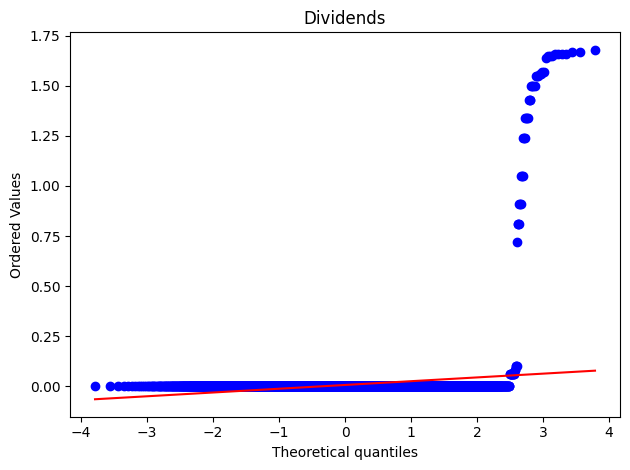

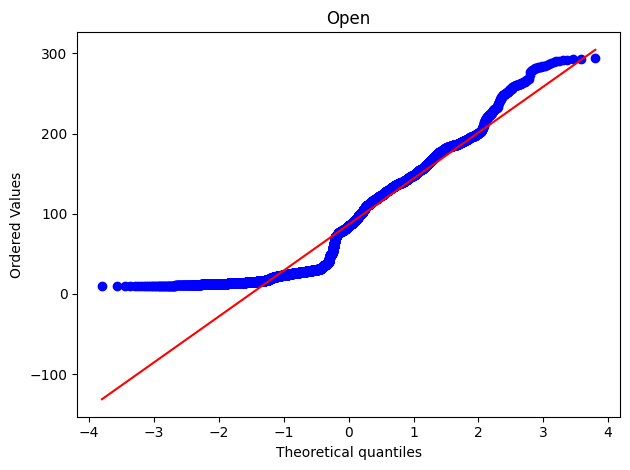

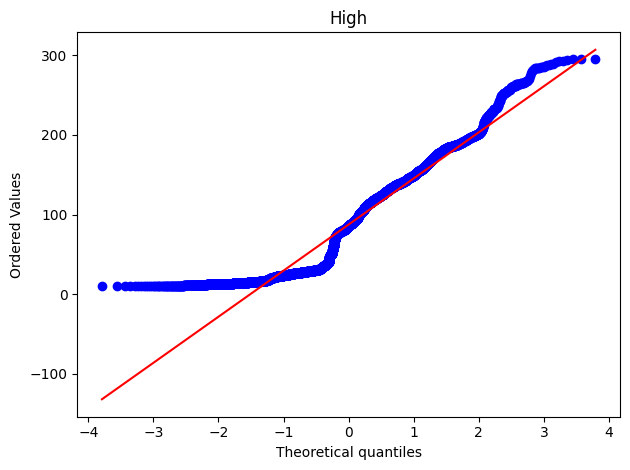

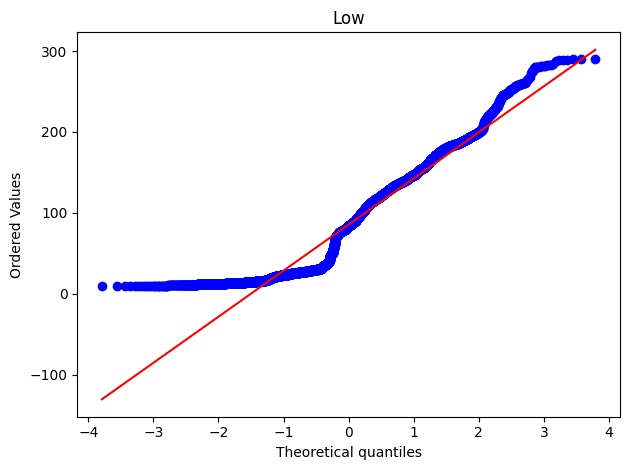

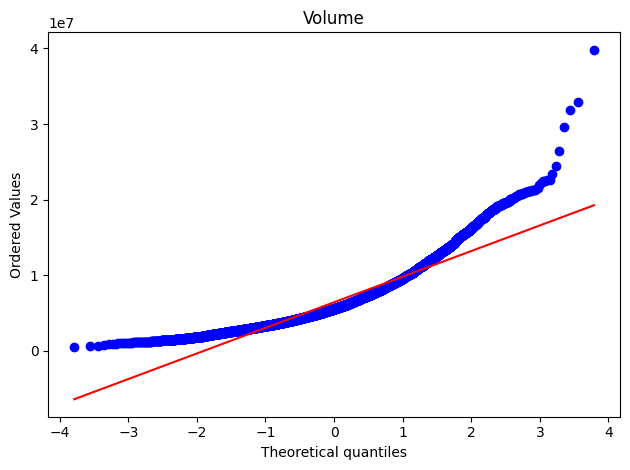

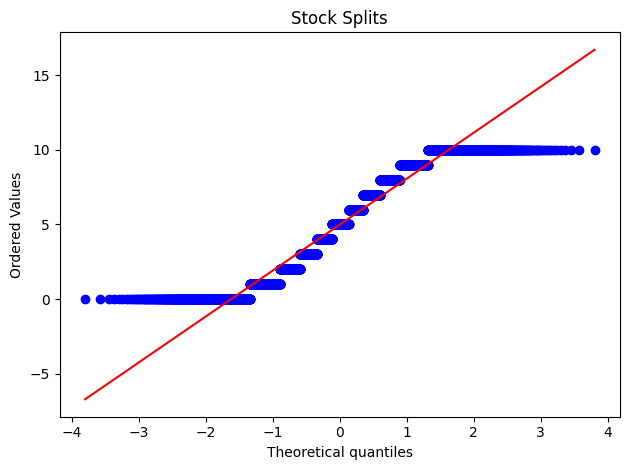

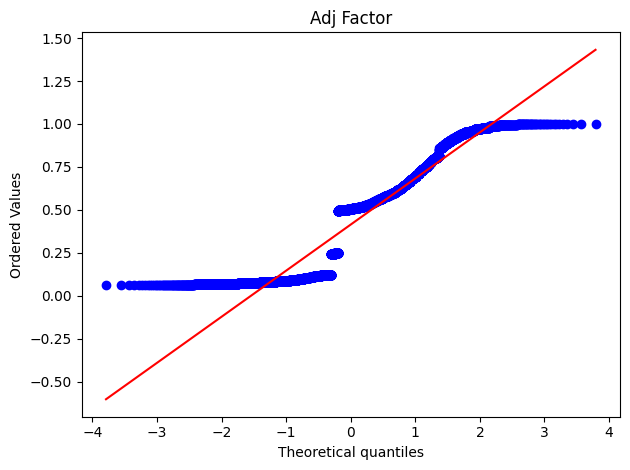

In [ ]:
for col in numerical_columns:
  st.probplot(df[col].dropna(), dist='norm', plot=plt)
  plt.title(f"{col}")
  plt.tight_layout()
  plt.show()

Итак, все задания первой лабораторной работы выполнены:

 Очистка данных (удаление пропусков, нормализация, удаление дубликатов)
Визуализация значимых признаков:
 диаграммы рассеяния
 ящики с усами
 гистограммы
 Корреляция данных (матрица корреляций)
 Использование статистических функций

# Лабораторая работа №2

В методических указаниях данной лабораторной работе используются 3 метода обучения модели:
- k-nn (Метод ближайший соседей)
- SVM (Метод опорных векторов)
- Random Forest (Случайный лес)

Однако по условиям работы решается задача классификации, однако в нашем случае для признака "Close" мы высчитываем непрерывное числовое значение, а значит предстоит решение задачи регрессии. Поэтому возьмём следующие 3 метода:
- Линейная регрессия
- LASSO
- Ридж-регрессия

Оценивать разные модели будем при помощи таких метрик как:
- R2
- MAE
- MSE

Сделаем некоторые шаги - общие для всех методов

Импортируем библиотеки

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import TimeSeriesSplit

Созаддим функцию, которая будет показывать:
- Сколько денежных условных единиц мы получили/потеряли, покупая акцию предсказанную, что она вырастет
- Сколько в среднем мы получаем денежных условных единиц за сделку
- Сколько всего сделок мы совершили
- Сколько из всех сделок которые мы совершили оказались в плюсе

In [ ]:
def open_close_report(y_test, y_pred, threshold=0.0):
    y_test = pd.Series(y_test)
    y_pred = pd.Series(y_pred, index=y_test.index)

    go_long = y_pred > threshold

    pnl_pct = pd.Series(np.where(go_long, y_test, 0.0), index=y_test.index, name="pnl_pct")

    n_trades = int(go_long.sum())
    winrate = float((pnl_pct[go_long] > 0).mean()) if n_trades > 0 else np.nan

    pnl_total_pct = float(pnl_pct.sum())
    pnl_mean_pct  = float(pnl_pct.mean())

    print(
        f"Sum of PTS: {pnl_total_pct:.3f} PTS\n"
        f"Mean PTS by deal: {pnl_mean_pct:.3f} PTS\n"
        f"Trades: {n_trades} | Winrate: {np.nan if np.isnan(winrate) else round(winrate,3)} | "
    )


Создадим функцию, которая будет показывать матрицу ошибок, где
- 1 - Цена акции растёт
- 0 - Цена акции падает

In [ ]:
def direction_confusion(y_true_ret, y_pred_ret):
    y_true_ret = np.asarray(y_true_ret, dtype=float)
    y_pred_ret = np.asarray(y_pred_ret, dtype=float)
    assert y_true_ret.shape == y_pred_ret.shape, "Размеры не совпадают"
    assert not np.isnan(y_true_ret).any() and not np.isnan(y_pred_ret).any(), "Есть NaN"

    act  = y_true_ret > 0
    pred = y_pred_ret > 0

    cm11 = int(np.sum( act &  pred))
    cm10 = int(np.sum( act & ~pred))
    cm01 = int(np.sum(~act &  pred))
    cm00 = int(np.sum(~act & ~pred))
    total = cm00+cm01+cm10+cm11

    print("Матрица ошибок")
    print(f"         pred 0    pred 1")
    print(f"true 0  {cm00:5d}     {cm01:5d}")
    print(f"true 1  {cm10:5d}     {cm11:5d}")
    print(f"total: {total}")

### Линейная регрессия

Попробуем обучить модель методом линейной регрессии

Импортируем библиотеку

In [ ]:
from sklearn.linear_model import LinearRegression

Зададим кросс-валидацию временного ряда

In [ ]:
tscv_lr = TimeSeriesSplit(n_splits=5)

Зададим пайплайн для обучения

In [ ]:
pipe_lr = Pipeline(steps=[
    ("model", LinearRegression())
])

Зададим сетку гиперпарамметров модели

In [ ]:
grid_lr = {
    "model__fit_intercept": [True, False],
    "model__positive": [False, True],
}

Обучим модель

In [ ]:
gs_lr = GridSearchCV(pipe_lr, grid_lr, cv=tscv_lr, scoring="r2", n_jobs=-1)
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model', LinearRegression())]),
             n_jobs=-1,
             param_grid={'model__fit_intercept': [True, False],
                         'model__positive': [False, True]},
             scoring='r2')

Посмотрим метрики оценивания модели

In [ ]:
y_pred_lr = gs_lr.predict(X_test)
print("LinearRegression | best:", gs_lr.best_params_,
      "| R2:", r2_score(y_test, y_pred_lr),
      "| MSE:", mean_squared_error(y_test, y_pred_lr),
      "| MAE:", mean_absolute_error(y_test, y_pred_lr)
      )

LinearRegression | best: {'model__fit_intercept': False, 'model__positive': True} | R2: -0.0007006285759627584 | MSE: 2.7862127749189076 | MAE: 1.172563071308064


Посмотрим метрики, полученные из наших собственных функций

In [ ]:
open_close_report(y_test, y_pred_lr, threshold=0.0)

Sum of PTS: 146.014 PTS
Mean PTS by deal: 0.049 PTS
Trades: 2842 | Winrate: 0.506 | 


In [ ]:
direction_confusion(y_test, y_pred_lr)

Матрица ошибок
         pred 0    pred 1
true 0     60      1405
true 1     70      1437
total: 2972


Визуализируем сравнение предсказанной и настоящей дельты

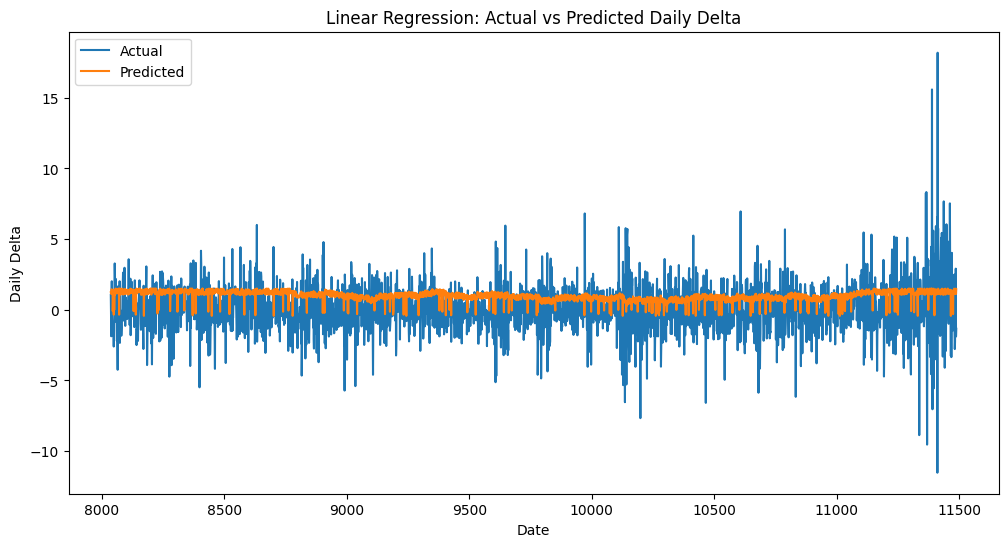

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_lr*10, label='Predicted')
plt.title('Linear Regression: Actual vs Predicted Daily Delta')
plt.xlabel('Date')
plt.ylabel('Daily Delta')
plt.legend()
plt.show()

## LASSO

Импортируем библиотеку

In [ ]:
from sklearn.linear_model import Lasso

Зададим кросс-валидацию временного ряда

In [ ]:
tscv_lasso = TimeSeriesSplit(n_splits=5)

Зададим пайплайн для обучения

In [ ]:
pipe_lasso = Pipeline(steps=[
    ("model", Lasso(max_iter=10000, tol=1e-3, selection="cyclic"))
])

Зададим сетку гиперпарамметров модели

In [ ]:
grid_lasso = {
    "model__alpha": np.logspace(-3, 1, 9),
}

Обучим модель

In [ ]:
gs_lasso = GridSearchCV(pipe_lasso, grid_lasso, cv=tscv_lasso, scoring="r2", n_jobs=-1)
gs_lasso.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model',
                                        Lasso(max_iter=10000, tol=0.001))]),
             n_jobs=-1,
             param_grid={'model__alpha': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01])},
             scoring='r2')

Посмотрим метрики оценивания модели

In [ ]:
y_pred_lasso = gs_lasso.predict(X_test)
print("Lasso | best:", gs_lasso.best_params_,
      "| R2:", r2_score(y_test, y_pred_lasso),
      "| MSE:", mean_squared_error(y_test, y_pred_lasso),
      "| MAE:", mean_absolute_error(y_test, y_pred_lasso)
      )

Lasso | best: {'model__alpha': np.float64(0.03162277660168379)} | R2: 0.0001719793001941916 | MSE: 2.7837832059323238 | MAE: 1.1697952169154566


Посмотрим метрики, полученные из наших собственных функций

In [ ]:
open_close_report(y_test, y_pred_lasso, threshold=0)

Sum of PTS: 157.425 PTS
Mean PTS by deal: 0.053 PTS
Trades: 2972 | Winrate: 0.507 | 


In [ ]:
direction_confusion(y_test, y_pred_lasso)

Матрица ошибок
         pred 0    pred 1
true 0      0      1465
true 1      0      1507
total: 2972


Визуализируем сравнение предсказанной и настоящей дельты

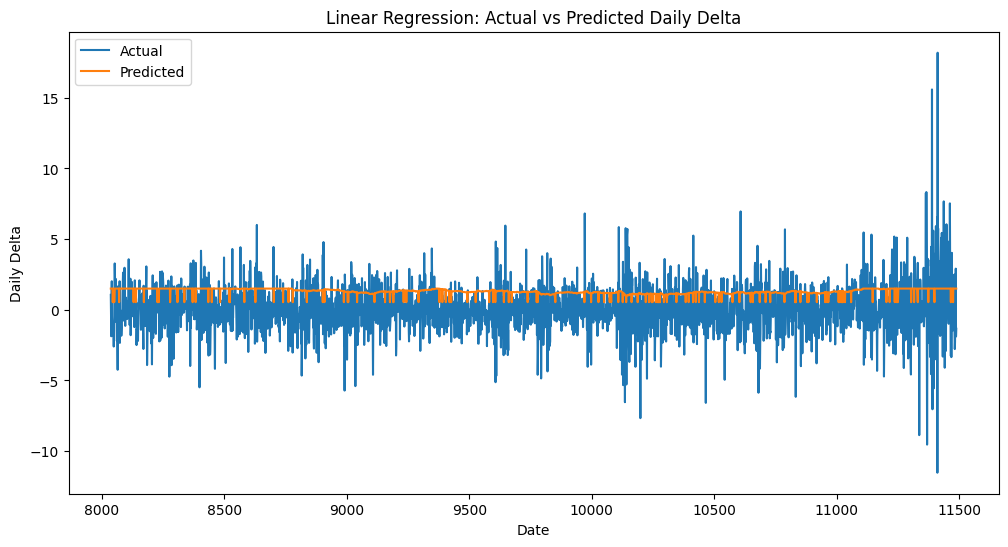

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_lasso*25, label='Predicted')
plt.title('Linear Regression: Actual vs Predicted Daily Delta')
plt.xlabel('Date')
plt.ylabel('Daily Delta')
plt.legend()
plt.show()

## Ридж-регрессия

Импортируем библиотеку

In [ ]:
from sklearn.linear_model import Ridge

Зададим кросс-валидацию временного ряда

In [ ]:
tscv_ridge = TimeSeriesSplit(n_splits=5)

Зададим пайплайн для обучения

In [ ]:
pipe_ridge = Pipeline(steps=[
    ("model", Ridge(random_state=42))
])

Зададим сетку гиперпарамметров модели

In [ ]:
grid_ridge = {
    "model__alpha": np.logspace(-3, 3, 13),
    "model__solver": ["auto", "cholesky", "lsqr", "sag", "saga"],
}

Обучим модель

In [ ]:
gs_ridge = GridSearchCV(pipe_ridge, grid_ridge, cv=tscv_ridge, scoring="r2", n_jobs=-1)
gs_ridge.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model', Ridge(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__alpha': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                         'model__solver': ['auto', 'cholesky', 'lsqr', 'sag',
                                           'saga']},
             scoring='r2')

Посмотрим метрики оценивания модели

In [ ]:
y_pred_ridge = gs_ridge.predict(X_test)
print("Lasso | best:", gs_ridge.best_params_,
      "| R2:", r2_score(y_test, y_pred_ridge),
      "| MSE:", mean_squared_error(y_test, y_pred_ridge),
      "| MAE:", mean_absolute_error(y_test, y_pred_ridge)
      )

Lasso | best: {'model__alpha': np.float64(1000.0), 'model__solver': 'saga'} | R2: 0.0013392352369887561 | MSE: 2.7805332595349435 | MAE: 1.1716939159529485


Посмотрим метрики, полученные из наших собственных функций

In [ ]:
open_close_report(y_test, y_pred_ridge, threshold=0)

Sum of PTS: 166.319 PTS
Mean PTS by deal: 0.056 PTS
Trades: 2875 | Winrate: 0.508 | 


In [ ]:
direction_confusion(y_test, y_pred_ridge)

Матрица ошибок
         pred 0    pred 1
true 0     51      1414
true 1     46      1461
total: 2972


Визуализируем сравнение предсказанной и настоящей дельты

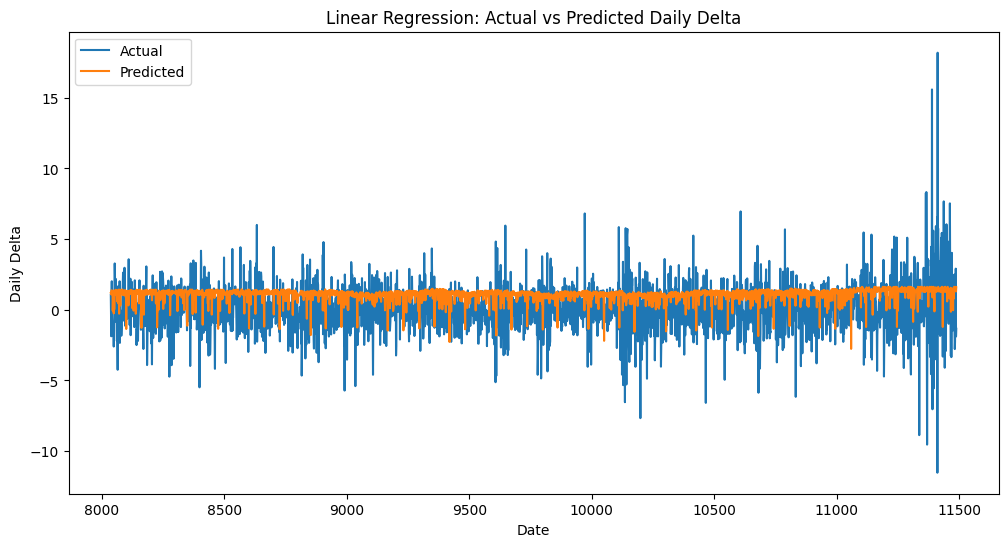

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_ridge*10, label='Predicted')
plt.title('Linear Regression: Actual vs Predicted Daily Delta')
plt.xlabel('Date')
plt.ylabel('Daily Delta')
plt.legend()
plt.show()

## Заключение по лабораторной работе №2

По критериям MAE/MSE все модели показали примерно одинаковый результат. По критерию R2 все модели оказались посредственными. А все из-за целевого признака, которые мало коррелирует с другими признаками. Именно из-за возникающего смещения и малых весов по матрице ошибок моделей мы видим, что модели почти всегда решают о повышении стоимость акций (Из-за смещения и положительной константы ). Если мы говорим о сосбтвенных метриках, то наблюдается следующее:

Linear Regression < LASSO < Ridge-Regression

Лабораторную работу, связанную с решением задач регрессии можно считать завершенной